In [90]:
import pandas as pd

from mamimo.datasets import load_fake_mmm
import matplotlib.pyplot as plt

data = load_fake_mmm()
data.head()

,TV,Radio,Banners,Sales
Date,,,,
2018-01-07,13528.1,0.00,0.00,4779.80
2018-01-14,0.0,5349.65,2218.93,8405.72
2018-01-21,0.0,4235.86,2046.96,7353.87
2018-01-28,0.0,3562.21,0.00,4351.05
2018-02-04,0.0,0.00,2187.29,5472.92


In [91]:
X = data.drop(columns=['Sales'])
y = data['Sales']

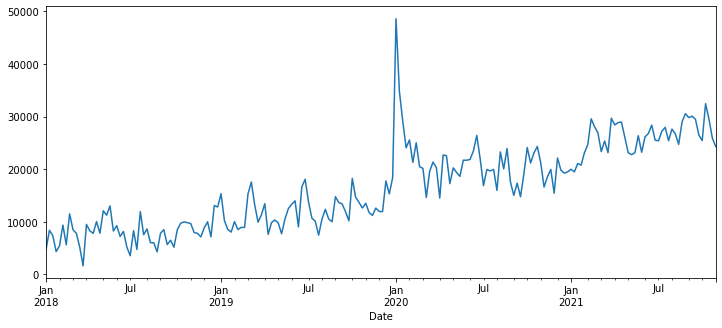

In [92]:
y.plot(figsize=(12, 5))
plt.show()

In [93]:
from mamimo.carryover import ExponentialCarryover
from mamimo.saturation import ExponentialSaturation
from mamimo.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [94]:
adstock = ColumnTransformer([
    ('tv_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['TV']),
     ('radio_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Radio']),
     ('banners_pipe', Pipeline([
            ('carryover', ExponentialCarryover()),
            ('saturation', ExponentialSaturation())
     ]), ['Banners']),]
)

model = Pipeline([
    ('adstock', adstock),
    ('regression', LinearRegression(positive=True))
])

In [95]:
print(model.fit(X, y).score(X, y))

0.10985072579909416


In [97]:
def plot_sales(target, predicted):
    sales_df = pd.DataFrame()
    sales_df["observed"] = target
    sales_df["predicted"] = predicted
    sales_df.plot(figsize=(12, 5))
    plt.show()

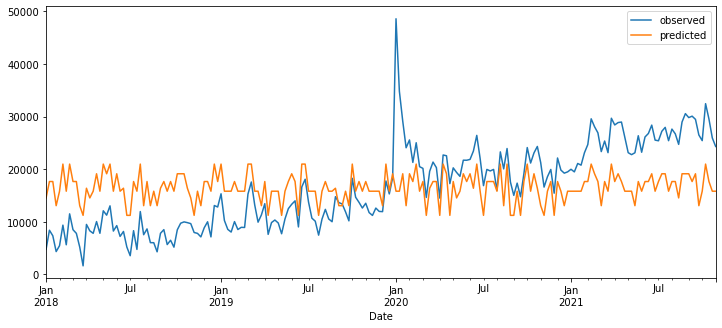

In [98]:
plot_sales(y, model.predict(X))

In [99]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tuned_model = RandomizedSearchCV(model,
								 param_distributions={
									 'adstock__tv_pipe__carryover__window': randint(1, 10),
									 'adstock__tv_pipe__carryover__strength': uniform(0, 1),
									 'adstock__tv_pipe__saturation__exponent': uniform(0, 1),
									 'adstock__radio_pipe__carryover__window': randint(1, 10),
									 'adstock__radio_pipe__carryover__strength': uniform(0, 1),
									 'adstock__radio_pipe__saturation__exponent': uniform(0, 1),
									 'adstock__banners_pipe__carryover__window': randint(1, 10),
									 'adstock__banners_pipe__carryover__strength': uniform(0, 1),
									 'adstock__banners_pipe__saturation__exponent': uniform(0,1),
								 },
                                 cv=TimeSeriesSplit(),
                                 random_state=0,
                                 n_iter=100)
tuned_model.fit(X, y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('adstock',
                                              ColumnTransformer(transformers=[('tv_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturation',
                                                                                                ExponentialSaturation())]),
                                                                               ['TV']),
                                                                              ('radio_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturati...
                                        'adstock__tv_pipe__carryover__strength': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C457978B0>,
                                        'adstock__tv_pipe__carryover__window': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C45B581F0>,
                                        'adstock__tv_pipe__saturation__exponent': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C45B0DD90>},
                   random_state=0)

In [100]:
tuned_model.best_params_

{'adstock__banners_pipe__carryover__strength': 0.6817399450693612,
 'adstock__banners_pipe__carryover__window': 1,
 'adstock__banners_pipe__saturation__exponent': 0.09749338421508524,
 'adstock__radio_pipe__carryover__strength': 0.8518536993666015,
 'adstock__radio_pipe__carryover__window': 1,
 'adstock__radio_pipe__saturation__exponent': 0.1598452868541913,
 'adstock__tv_pipe__carryover__strength': 0.04680635471218875,
 'adstock__tv_pipe__carryover__window': 4,
 'adstock__tv_pipe__saturation__exponent': 0.0038603515102610952}

So the model thinks that the TV carryover effect lasts 4 weeks with about 4.68% of the effect carried into the next week, for example. Statements like this are gold for the business.

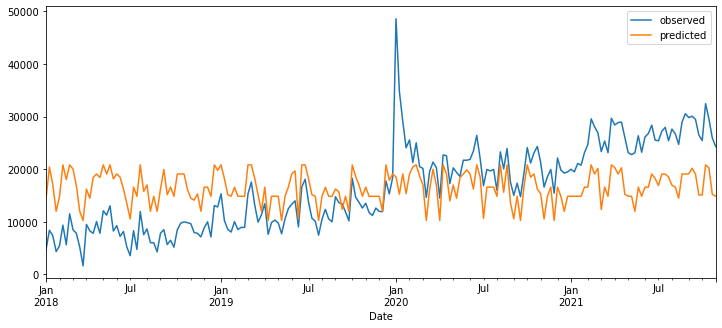

In [101]:
plot_sales(y, tuned_model.predict(X))

#### Incorporating Time Features

In [102]:
y[y == y.max()]

Date
2020-01-05    48569.71
Freq: W-SUN, Name: Sales, dtype: float64

In [104]:
from mamimo.time_utils import add_time_features, add_date_indicators

X = (X
	 .pipe(add_time_features, month=True)
	 .pipe(add_date_indicators, special_date=["2020-01-05"])
	 .assign(trend=range(200))
	 )
X

,TV,Radio,Banners,month,special_date,trend
Date,,,,,,
2018-01-07,13528.10,0.00,0.00,1,0,0
2018-01-14,0.00,5349.65,2218.93,1,0,1
2018-01-21,0.00,4235.86,2046.96,1,0,2
2018-01-28,0.00,3562.21,0.00,1,0,3
2018-02-04,0.00,0.00,2187.29,2,0,4
...,...,...,...,...,...,...
2021-10-03,0.00,0.00,1691.68,10,0,195
2021-10-10,11543.58,4615.35,2518.88,10,0,196
2021-10-17,0.00,4556.16,1919.19,10,0,197


In [105]:
from mamimo.time_utils import PowerTrend
from sklearn.preprocessing import OneHotEncoder

cats =  [list(range(1, 13))] # different months, known beforehand

preprocess = ColumnTransformer(
	[
		('tv_pipe', Pipeline([
			('carryover', ExponentialCarryover()),
			('saturation', ExponentialSaturation())
		]), ['TV']),
		('radio_pipe', Pipeline([
			('carryover', ExponentialCarryover()),
			('saturation', ExponentialSaturation())
		]), ['Radio']),
		('banners_pipe', Pipeline([
			('carryover', ExponentialCarryover()),
			('saturation', ExponentialSaturation())
		]), ['Banners']),
		('month', OneHotEncoder(sparse=False, categories=cats), ['month']),
		('trend', PowerTrend(), ['trend']),
		('special_date', ExponentialCarryover(), ['special_date'])
	]
)

new_model = Pipeline([('preprocess', preprocess),
                      ('regression', LinearRegression(positive=True,
                                                      fit_intercept=False)) # no intercept because of the months)
                    ])
new_model.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('tv_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['TV']),
                                                 ('radio_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['Radio']),
                                                 ('banners_pipe',
                                                  Pipeline(steps=[('carryover',
                                                                   ExponentialCarryover()),
                                                                  ('saturation',
                                                                   ExponentialSaturation())]),
                                                  ['Banners']),
                                                 ('month',
                                                  OneHotEncoder(categories=[[1,
                                                                             2,
                                                                             3,
                                                                             4,
                                                                             5,
                                                                             6,
                                                                             7,
                                                                             8,
                                                                             9,
                                                                             10,
                                                                             11,
                                                                             12]],
                                                                sparse=False),
                                                  ['month']),
                                                 ('trend', PowerTrend(),
                                                  ['trend']),
                                                 ('special_date',
                                                  ExponentialCarryover(),
                                                  ['special_date'])])),
                ('regression',
                 LinearRegression(fit_intercept=False, positive=True))])

In [107]:
print(new_model.fit(X, y).score(X, y))

0.931447266586064


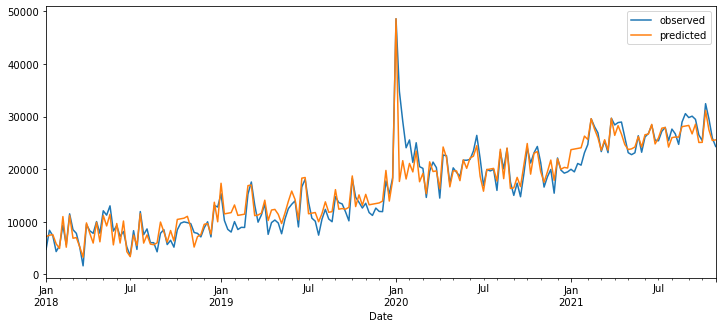

In [108]:
plot_sales(target=y, predicted=new_model.predict(X))

In [109]:
tuned_new_model = RandomizedSearchCV(
	new_model,
	param_distributions={
		'preprocess__tv_pipe__carryover__window': randint(1, 10),
		'preprocess__tv_pipe__carryover__strength': uniform(0, 1),
		'preprocess__tv_pipe__saturation__exponent': uniform(0, 1),
		'preprocess__radio_pipe__carryover__window': randint(1, 10),
		'preprocess__radio_pipe__carryover__strength': uniform(0, 1),
		'preprocess__radio_pipe__saturation__exponent': uniform(0, 1),
		'preprocess__banners_pipe__carryover__window': randint(1, 10),
		'preprocess__banners_pipe__carryover__strength': uniform(0, 1),
		'preprocess__banners_pipe__saturation__exponent': uniform(0, 1),
		'preprocess__trend__power': uniform(0, 2),           # new
		'preprocess__special_date__window': randint(1, 10),  # new
		'preprocess__special_date__strength': uniform(0, 1), # new
	},
	cv=TimeSeriesSplit(),
	random_state=0,
	n_iter=1000, # some more iterations, takes more time
)
tuned_new_model.fit(X, y)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(transformers=[('tv_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('saturation',
                                                                                                ExponentialSaturation())]),
                                                                               ['TV']),
                                                                              ('radio_pipe',
                                                                               Pipeline(steps=[('carryover',
                                                                                                ExponentialCarryover()),
                                                                                               ('satur...
                                        'preprocess__tv_pipe__carryover__strength': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C46CBC7C0>,
                                        'preprocess__tv_pipe__carryover__window': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C46E2C1F0>,
                                        'preprocess__tv_pipe__saturation__exponent': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026C46E1C5B0>},
                   random_state=0)

In [111]:
print(tuned_new_model.score(X, y))

0.9492425634302487


In [112]:
tuned_new_model.best_params_

{'preprocess__banners_pipe__carryover__strength': 0.9803750792296568,
 'preprocess__banners_pipe__carryover__window': 1,
 'preprocess__banners_pipe__saturation__exponent': 0.17633290746448915,
 'preprocess__radio_pipe__carryover__strength': 0.9417421432655166,
 'preprocess__radio_pipe__carryover__window': 1,
 'preprocess__radio_pipe__saturation__exponent': 0.06918480469264277,
 'preprocess__special_date__strength': 0.8667029791268241,
 'preprocess__special_date__window': 6,
 'preprocess__trend__power': 1.463860555363072,
 'preprocess__tv_pipe__carryover__strength': 0.3422263312509606,
 'preprocess__tv_pipe__carryover__window': 1,
 'preprocess__tv_pipe__saturation__exponent': 0.3591065076533001}

Great, so the trend is not linear, but of the form t^1.464 instead, meaning even stronger than linear.

In [145]:
best_model = tuned_new_model.best_estimator_

pd.Series(best_model.named_steps['regression'].coef_,
          index=best_model[:-1].get_feature_names_out())

tv_pipe__TV                    3389.936227
radio_pipe__Radio              2278.722723
banners_pipe__Banners          2455.014524
month__month_1                 2724.333162
month__month_2                 2991.294009
month__month_3                 4080.414741
month__month_4                 4542.696378
month__month_5                 3484.384654
month__month_6                 3785.648376
month__month_7                 2497.006415
month__month_8                 2068.016338
month__month_9                 1883.746572
month__month_10                2179.914547
month__month_11                2135.526582
month__month_12                2233.341158
trend__trend                      9.801207
special_date__special_date    96822.051131
dtype: float64

##### Computing The Channel Contributions

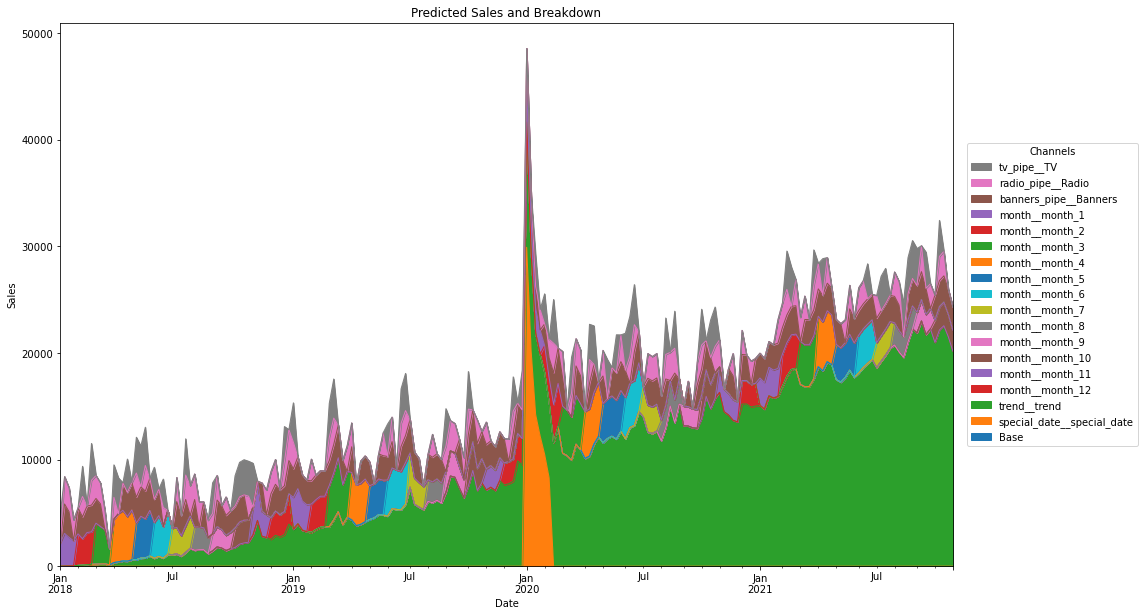

In [146]:
from mamimo.analysis import breakdown

contributions = breakdown(best_model, X, y)
ax = contributions[contributions.columns[-1::-1]].plot.area(figsize=(16, 10),
                             linewidth=1,
                             title="Predicted Sales and Breakdown",
                             ylabel="Sales",
                             xlabel="Date",)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],
          labels[::-1],
          title="Channels",
          loc="center left",
          bbox_to_anchor=(1.01, 0.5),
)
plt.show()

<AxesSubplot:xlabel='Date'>

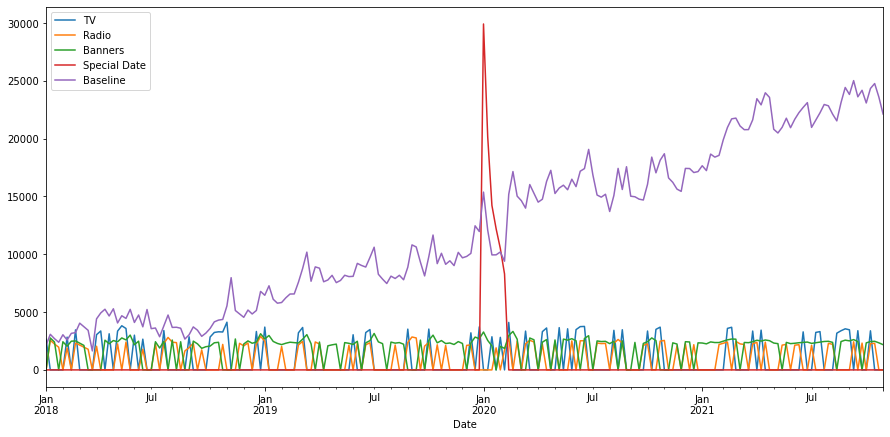

In [157]:
contributions[contributions.columns[-1::-1]].plot(figsize=(15, 7))

In [149]:
contributions.columns[-1::-1]

Index(['Base', 'special_date__special_date', 'trend__trend', 'month__month_12',
       'month__month_11', 'month__month_10', 'month__month_9',
       'month__month_8', 'month__month_7', 'month__month_6', 'month__month_5',
       'month__month_4', 'month__month_3', 'month__month_2', 'month__month_1',
       'banners_pipe__Banners', 'radio_pipe__Radio', 'tv_pipe__TV'],
      dtype='object')

In [150]:
contributions.head()

,tv_pipe__TV,radio_pipe__Radio,banners_pipe__Banners,month__month_1,month__month_2,month__month_3,month__month_4,month__month_5,month__month_6,month__month_7,month__month_8,month__month_9,month__month_10,month__month_11,month__month_12,trend__trend,special_date__special_date,Base
Date,,,,,,,,,,,,,,,,,,
2018-01-07,2650.06596,0.000000,0.000000,2129.734040,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2018-01-14,0.00000,2564.894812,2763.326118,3066.466984,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.032086,0.0,0.0
2018-01-21,0.00000,2238.769808,2411.970680,2676.567347,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.562164,0.0,0.0
2018-01-28,0.00000,1962.555920,0.000000,2346.339079,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.155001,0.0,0.0
2018-02-04,0.00000,0.000000,2433.684828,0.000000,2965.305002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73.930170,0.0,0.0


In [151]:
group_channels = {'Baseline': [f'month__month_{i}' for i in range(1, 13)] + ['Base', 'trend__trend']} # read: 'Baseline consists of the months, base and trend.'
# You can add more groups!
contributions = breakdown(best_model, X, y, group_channels)

In [152]:
contributions.head()

,tv_pipe__TV,radio_pipe__Radio,banners_pipe__Banners,special_date__special_date,Baseline
Date,,,,,
2018-01-07,2650.06596,0.000000,0.000000,0.0,2129.734040
2018-01-14,0.00000,2564.894812,2763.326118,0.0,3077.499070
2018-01-21,0.00000,2238.769808,2411.970680,0.0,2703.129511
2018-01-28,0.00000,1962.555920,0.000000,0.0,2388.494080
2018-02-04,0.00000,0.000000,2433.684828,0.0,3039.235172


In [153]:
contributions.columns

Index(['tv_pipe__TV', 'radio_pipe__Radio', 'banners_pipe__Banners',
       'special_date__special_date', 'Baseline'],
      dtype='object')

In [155]:
#Renaming the columns
contributions.columns = ['TV', 'Radio', 'Banners', 'Special Date', 'Baseline']
contributions.columns[-1::-1]

Index(['Baseline', 'Special Date', 'Banners', 'Radio', 'TV'], dtype='object')

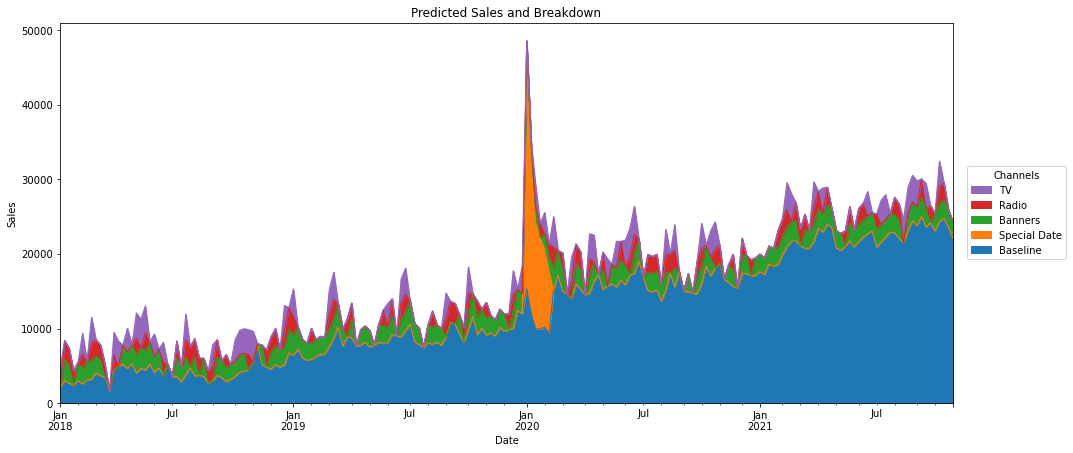

In [156]:
ax = contributions[contributions.columns[-1::-1]].plot.area(figsize=(16, 7),
                             linewidth=1,
                             title="Predicted Sales and Breakdown",
                             ylabel="Sales",
                             xlabel="Date",)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1],
          labels[::-1],
          title="Channels",
          loc="center left",
          bbox_to_anchor=(1.01, 0.5),
)

In [143]:
for channel in ['TV', 'Radio', 'Banners']:
	roi = contributions[channel].sum() / X[channel].sum()
	print(f'{channel}: {roi:.2f}')

TV: 0.33
Radio: 0.47
Banners: 1.23
